<div style="text-align: right"><b> Ana Valentina López Chacón & Isabella Martínez Martínez & Sara Julieth Zuleta Quevedo. </b></div>

# **Proyecto 1 de Introducción al Procesamiento de Lenguaje Natural**

Para este proyecto deberan realizar web scrapping, usando la API de Tweeter (v2). Esta API nos permite recolectar tweets con diversas configuraciones y parámetros, búsquedas con filtros, etc. Además nos permite sectorizar, definir el lugar, los tiempos, entre otros.

Para usar con todo el potencial esta API necesitamos una cuenta premium o académica. Sin embargo, este proyecto tan sólo necesita una cuenta *essential* (si quieren usar más información, más detallada, lo podemos mirar). La mayor limitante es que trabajaremos sobre la última semana. 

Es importante que lean y apliquen el notebook `Twitter_API_v2_Guide_essential.ipynb`, el cual explica de forma sencilla como usar la API (lo he modificado para la cuenta essential y con alguna configuración particular). 

Cada proyecto tendrá las siguentes partes:

1. **Obtención de los datos mediante la API**
2. **Preprocesamiento del texto**: tokenización (recomiendo usar `nltk.tokenize.TweetTokenizer`), lematización, filtrado de stop words etc. En este punto hay que tener cuidado, porque trabajaremos en el idioma español y tienen una configuración especial al ser tweets (recomiendo ver [este blog](https://jairoandres.com/spacy-procesando-tweets/)).
3. **Análisis de tópicos**: con el dataset obtenido, deberán analizar cuales son los temas principales a partir de una matriz término-documento y de su respectiva factorización matricial (SVD, NFM, PCA). Esto por ejemplo, podría indicar algunas tendencias diarias, o durante la última semana.
4. **Word2vec y similares**: se deberá entrenar modelos de word2vec para tener una representación vectorial de las palabras y posteriormente poderlas analizar y/o crear modelos de machine learning.
5. **Interfaz gráfica**: Gradio es un framework increíblemente sencillo para realizar interfaces super sencillas y llevar los modelos a producción. No les pediré en este proyecto llevarlo a un servidor (que hoy en día es super sencillo), pero si al menos realizar una sencilla interfaz gráfica sobre el notebook de jupyter. Recomiendo que lean este [tutorial de Gradio](https://gradio.app/getting_started/).

Además de los cinco pasos anteriores, es importante que realicen gráficos y visualizaciones que ayuden a la interpretación. No olviden ir analizando y comentando los hallazgos, y sobretodo **concluir**. El entregable es un notebook de Jupyter, debidamente presentado y comentado.

Debe también realizar un pequeño video promocional de la aplicación (de una duración máxima de tres minutos, no tiene que explicar en detalle el funcionamiento, sino vender el producto).

# **Implementación**

**DISCLAIMER:** Correr el notebook desde la sección **Datos Limpios** con el fin de optimizar recursos y tiempo.

### **Obtención de datos**


Se realiza el proceso de obtención de datos mediante la API, sin embargo, esta recoleccíon se ejecutó previamente y ya se obtuvo el dataset. Por esto, es posible omititr correr esta sección.

In [39]:
# For sending GET requests from the API
import requests

# For saving access tokens and for file management when creating and adding to the dataset
import os

# For dealing with json responses we receive from the API
import json

# For displaying the data after
import pandas as pd

# For saving the response data in CSV format
import csv

# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata

#To add wait time between requests
import time


In [40]:
os.environ["TOKEN"] = "API_TOKEN_HERE"

In [41]:
def auth():
    return os.getenv("TOKEN")


def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers


def create_url(keyword, start_date, end_date, max_results=10):

    # Change to the endpoint you want to collect data from
    search_url = "https://api.twitter.com/2/tweets/search/recent"

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)


def connect_to_endpoint(url, headers, params, next_token=None):
    # params object received from create_url function
    params['next_token'] = next_token
    response = requests.request("GET", url, headers=headers, params=params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


In [42]:
def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, source, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [43]:
#Inputs for tweets
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "Colombia lang:es"
start_list =    ['2022-02-17T00:00:00.000Z',
                 '2022-02-18T00:00:00.000Z',
                 '2022-02-19T00:00:00.000Z',
                 '2022-02-20T00:00:00.000Z',
                 '2022-02-21T00:00:00.000Z']

end_list =      ['2022-02-18T00:00:00.000Z',
                 '2022-02-19T00:00:00.000Z',
                 '2022-02-20T00:00:00.000Z',
                 '2022-02-21T00:00:00.000Z',
                 '2022-02-22T00:00:00.000Z']
max_results = 100

#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open("more_data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()

for i in range(0,len(start_list)):

    # Inputs
    count = 0 # Counting tweets per time period
    max_count = 20000 # Max tweets per time period
    flag = True
    next_token = None
    
    # Check if flag is true
    while flag:
        # Check if max_count reached
        if count >= max_count:
            break
        print("-------------------")
        print("Token: ", next_token)
        url = create_url(keyword, start_list[i],end_list[i], max_results)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
        result_count = json_response['meta']['result_count']

        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
            print("Next Token: ", next_token)
            if result_count is not None and result_count > 0 and next_token is not None:
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, "more_data.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(1)                
        # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, "more_data.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(1)
            
            #Since this is the final request, turn flag to false to move to the next time period.
            flag = False
            next_token = None
        time.sleep(1)
print("Total number of results: ", total_tweets)


-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fpe76kp1lwsukx72r4yirgs40yam4d
Start Date:  2022-02-17T00:00:00.000Z
# of Tweets added from this response:  100
Total # of Tweets added:  100
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe76kp1lwsukx72r4yirgs40yam4d
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fpe76kp1lwsmr0poifsitd7144fwjh
Start Date:  2022-02-17T00:00:00.000Z
# of Tweets added from this response:  100
Total # of Tweets added:  200
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe76kp1lwsmr0poifsitd7144fwjh
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fpe76kp1lwsez93clkou2g33b54bct
Start Date:  2022-02-17T00:00:00.000Z
# of Tweets added from this response:  100
Total # of Tweets added:  300
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe76kp1lwsez93clkou2g33b54bct
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fpe76kp1lwrztrdeqtgkh7pash3szh
Star

KeyError: 'place_id'

## **Proyecto A - Sinónimos y Antónimos**

Deberá construir un dataset con la mayor cantidad de tweets en español que pueda (con las limitaciones de la cuenta essential) y construir un diccionario de sinónimos y antónimos con base en la similitud entre los vectores de palabras, de un modelo word2vec. Pruebe diferentes configuraciones del modelo (es decir, modelos skip-gram, CBOW, de diferente tamaño de ventana, diferente tamaño del vector, etc), y observe cuál funciona mejor. El diccionario se sinónimos y antónimos debe mostrarse en una interfaz de usuario sencilla. La aplicación debe producir al menos un sinónimo y un antónimo por la palabra escrita.

También, deben analizar tópicos mediante factorización de matrices de término-documento, y realizando un clustering sobre los vectores de palabra word2vec (recomiendo GMM) para identificar patrones o tendencias.

### **Preprocesamiento**

Se importan las librerias necesarias para realizar el procesamiento previo de los datos y se lee el conjunto de datos recolectado en la sección anterior. 

In [1]:
import pandas as pd 
import re
from nltk.tokenize import TweetTokenizer
import spacy
import unicodedata
import numpy as np

df = pd.read_csv("more_data.csv")
df.head()


C:\Users\Isabella\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (0,3,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
0,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
1,108861705,2022-02-15 23:59:59+00:00,,1493736883125370882,es,0,0,0,238,Twitter for Android,RT @BlancoGustavo10: El Cerdo de Colombia @Iva...
2,1043351352255160320,2022-02-15 23:59:59+00:00,,1493736882106245120,es,0,0,0,0,Twitter for Android,@JuanCar99077589 @elojodiestro @intiasprilla Y...
3,3636778473,2022-02-15 23:59:59+00:00,,1493736880034267140,es,0,0,0,282,Twitter for Android,RT @Vahiaaa: Piedad Córdoba simplemente es una...
4,878061735483240449,2022-02-15 23:59:58+00:00,,1493736877932920833,es,0,0,0,19,Twitter Web App,RT @perez_otro: Entre los compradores de biene...


In [2]:
df = df.drop(0)
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
1,108861705,2022-02-15 23:59:59+00:00,,1493736883125370882,es,0,0,0,238,Twitter for Android,RT @BlancoGustavo10: El Cerdo de Colombia @Iva...
2,1043351352255160320,2022-02-15 23:59:59+00:00,,1493736882106245120,es,0,0,0,0,Twitter for Android,@JuanCar99077589 @elojodiestro @intiasprilla Y...
3,3636778473,2022-02-15 23:59:59+00:00,,1493736880034267140,es,0,0,0,282,Twitter for Android,RT @Vahiaaa: Piedad Córdoba simplemente es una...
4,878061735483240449,2022-02-15 23:59:58+00:00,,1493736877932920833,es,0,0,0,19,Twitter Web App,RT @perez_otro: Entre los compradores de biene...
5,1366056822352863232,2022-02-15 23:59:58+00:00,,1493736877609861121,es,0,0,0,718,Twitter for Android,RT @jbedoyalima: Es mi deseo pensar que @IBeta...


Finalmente, se cuenta con 78904 tweets.

In [3]:
len(df)

78904

Es importante limpiar y preprocesar los datos para asegurar el funcionamiento correcto del modelo y eliminar caracteres especiales, eliminar *stop-words*, realizar lematizacion, etc. Con el fin de obtener un resultado satisfactorio en la siguiente sección se necesita el modulo ```es_core_news_sm``` de `spacy`. Utilice el siguiente comando para su instalación: python -m spacy download es_core_news_sm.

In [4]:
def convert_listwords_text(list_words):
    text = ""
    for word in list_words:
        text = text + " " + word
    return text[1:]


def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

nlp = spacy.load("es_core_news_sm")
tk = TweetTokenizer()

def preprocessing_tweet(tweet):
    tweet = tweet.lower()
    tweet_words = tk.tokenize(tweet)

    list_tokens = []
    for word in tweet_words:
        word = remove_accents(word)
        if len(word) > 1:
            if word[0] == "@" or word == "rt" or word[:4] == "http" or word[0] == "#" or word[-3:] == "...":
                continue
            word = re.sub(r'[^\w]', '', word)
            list_tokens.append(word)

    new_tweet = convert_listwords_text(list_tokens)

    doc = nlp(new_tweet)
    list_word = []
    
    for token in doc:
        if(
            not token.is_punct 
            and not token.is_stop 
            and not token.like_url
            and not token.is_space
            and not token.like_num
            and not token.pos_ == "CONJ"
        ):
            list_word.append(remove_accents(token.lemma_))
    
    return convert_listwords_text(list_word)


Se aplica la función anterior a todo el conjunto de datos.

In [5]:
df["clean_tweet"] = df["tweet"].apply(preprocessing_tweet)

df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,clean_tweet
1,108861705,2022-02-15 23:59:59+00:00,,1493736883125370882,es,0,0,0,238,Twitter for Android,RT @BlancoGustavo10: El Cerdo de Colombia @Iva...,cerdo colombia otan denunciar apoyo rusia vene...
2,1043351352255160320,2022-02-15 23:59:59+00:00,,1493736882106245120,es,0,0,0,0,Twitter for Android,@JuanCar99077589 @elojodiestro @intiasprilla Y...,evidentemente ud narcotraficante bacrim colomb...
3,3636778473,2022-02-15 23:59:59+00:00,,1493736880034267140,es,0,0,0,282,Twitter for Android,RT @Vahiaaa: Piedad Córdoba simplemente es una...,piedad cordobo simplemente subversiva cobarde ...
4,878061735483240449,2022-02-15 23:59:58+00:00,,1493736877932920833,es,0,0,0,19,Twitter Web App,RT @perez_otro: Entre los compradores de biene...,comprador bien raiz florida colombiano segundo...
5,1366056822352863232,2022-02-15 23:59:58+00:00,,1493736877609861121,es,0,0,0,718,Twitter for Android,RT @jbedoyalima: Es mi deseo pensar que @IBeta...,deseo pensar vivir colombia confusion francofo...


Finalmente, se guarda el nuevo *dataset* para ahorrar espacio en memoria y no tener que realizar este proceso inoficiosamente.

In [6]:
df.to_csv('more_data_clean.csv', index=False)


### **Datos limpios**

Se importan las librerias pertinentes para el desarrollo del proyecto. Además, se lee el conjunto de datos final que se guardó en la sección anterior.

In [1]:
import numpy as np
import unicodedata
import spacy
from nltk.tokenize import TweetTokenizer
import re
import pandas as pd

df = pd.read_csv("more_data_clean.csv")
df.head()


C:\Users\valel\AppData\Local\Temp\ipykernel_12960\1209892045.py:8: DtypeWarning: Columns (0,3,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("more_data_clean.csv")


,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,clean_tweet
0,108861705,2022-02-15 23:59:59+00:00,,1493736883125370882,es,0,0,0,238,Twitter for Android,RT @BlancoGustavo10: El Cerdo de Colombia @Iva...,cerdo colombia otan denunciar apoyo rusia vene...
1,1043351352255160320,2022-02-15 23:59:59+00:00,,1493736882106245120,es,0,0,0,0,Twitter for Android,@JuanCar99077589 @elojodiestro @intiasprilla Y...,evidentemente ud narcotraficante bacrim colomb...
2,3636778473,2022-02-15 23:59:59+00:00,,1493736880034267140,es,0,0,0,282,Twitter for Android,RT @Vahiaaa: Piedad Córdoba simplemente es una...,piedad cordobo simplemente subversiva cobarde ...
3,878061735483240449,2022-02-15 23:59:58+00:00,,1493736877932920833,es,0,0,0,19,Twitter Web App,RT @perez_otro: Entre los compradores de biene...,comprador bien raiz florida colombiano segundo...
4,1366056822352863232,2022-02-15 23:59:58+00:00,,1493736877609861121,es,0,0,0,718,Twitter for Android,RT @jbedoyalima: Es mi deseo pensar que @IBeta...,deseo pensar vivir colombia confusion francofo...


### **Análisis de Tópicos**

En esta sección se llevará a cabo un análisis de tópicos mediante una matriz término-documento, generada mediante el método TfidVectorizer.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer()
# el .todense() no funciona por temas de tamaño
vectors = vectorizer.fit_transform(df["clean_tweet"].values.astype('str'))
vocab = np.array(vectorizer.get_feature_names_out())

print(vectors.shape)


(78904, 25830)


En primer lugar, se realiza una una factorización SVD.

In [3]:
from scipy.sparse.linalg import svds
from sklearn import decomposition
from scipy import linalg


Debido a cuestiones de tiempo, y del enorme tamaño de las matrices consideradas, se limita la salida de la función svds para que considere 500 valores.

In [4]:
#U, S, V = linalg.svd(vectors, full_matrices = False)
U, S, V = svds(vectors, k = 500)
print(U.shape, S.shape, V.shape)


(78904, 500) (500,) (500, 25830)


Se revisa rápidamente los primeros 6 elementos del vector S.

In [5]:
S[:6]

array([5.38217621, 5.38591091, 5.39395136, 5.39894247, 5.40497286,
       5.40770246])

Se visualiza mediante una gráfica la totalidad del vector S para identificar las componentes más importantes.

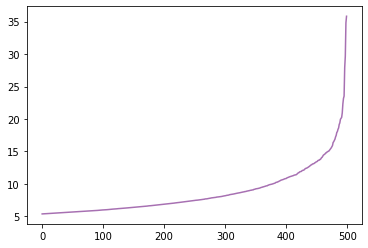

In [6]:
import matplotlib.pyplot as plt 
plt.plot(S, color='#A770B2')


Se define la función show_topics para identificar tópicos importantes que se pueden extraer como resultado de la factorización de matrices.

In [7]:
max_words = 8


def show_topics(a, vocab):
    def top_words(t): return [vocab[i]
                              for i in np.argsort(t)[:-max_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]


Se toman las ultimas 10 entradas de la matriz V.

In [8]:
#show_topics(V[:10], vocab)
show_topics(V[-10:], vocab)

['senor denuncia cruelmente publicar trar golpeado madrugada lopez',
 'colombia villa artista emergente tracatra duro nominada video',
 'colombia el presidente koki conejo jorge rodriguez banda',
 'equipo consulta democratico centro vot congreso noche jamundi',
 'jamundi cambiar historia valle cauca decidir pueblo mostrar',
 'derechos humanos naciones unidas alta instar comisionada oficina',
 'madrid foro asalto ensayo bloqueo colombi vandalismo convocar',
 'gobierno villa aido tramita suprema solicitar extradicion merlano',
 'gobierno aido extradicion merlano suprema tramita solicitar corte',
 'villa artista colombia gobierno nominada tracatra emergente video']

Es posible ver como los topicos seleccionados giran en un entorno politico, lo cual tiene sentido considerando la fuente de información. Ahora se realiza una factorización NMF la cual presenta un resultado más eficiente en terminos de tiempo de ejecución que la SVD. 

In [9]:
m, n = vectors.shape 
d = 10 

clf = decomposition.NMF(n_components = d, init = "nndsvd", random_state = 0, tol = 0.01)

W = clf.fit_transform(vectors)
H = clf.components_

print(W.shape)
print(H.shape)

(78904, 10)
(10, 25830)


Luego, empleando la función definida previamente se muestran los topicos de la matriz H.

In [10]:
show_topics(H, vocab)

['villa artista nominada tracatra emergente duro video ano',
 'gobierno aido extradicion merlano tramita suprema solicitar corte',
 'colombia petro presidente cambio el pacto gustavo venezuela',
 'madrid foro asalto ensayo bloqueo vandalismo colombi convocar',
 'derechos humanos naciones unidas alta instar comisionada oficina',
 'jamundi cambiar historia valle cauca decidir mostrar pueblo',
 'equipo consulta centro democratico congreso vot noche votar',
 'acabar valla prohibir censuran difundanla abu enterar cne',
 'perpetrado nun cabral pedro impunidad secuestro cumplir papa',
 'senor denuncia publicar cruelmente trar golpeado madrugada lopez']

Note que cada tópico alberga bastante sentido y representa ideas claras sobre distintas situaciones del país. Por ejemplo, las jornadas electorales en el sexto tópico, la extradición de Aida Merlano en el segundo, las naciones unidas en el cuarto, entre otros. Ahora bien, es posible llevar a cabo un análisis de componentes principales (PCA) en el que se obtienen 6 componentes.

In [11]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(6)

#pca = PCA(n_components = 6)
pca.fit_transform(vectors)


array([[ 3.22358419e-02,  2.06231138e-02,  6.98935894e-02,
        -4.57459977e-02, -6.19576612e-04, -2.91171546e-03],
       [ 2.25059896e-02,  1.38805958e-02,  5.13132859e-02,
        -3.03018913e-02, -4.72066342e-04, -3.14252854e-03],
       [ 2.79205163e-03,  2.39683296e-03,  7.36989514e-03,
        -5.39575806e-03, -3.81054945e-05, -4.35805959e-04],
       ...,
       [ 1.39604282e-02,  1.06458460e-02,  8.45542293e-02,
         3.34077046e-02, -9.12365783e-03, -1.01385041e-02],
       [ 1.16265157e-03,  8.75240861e-04,  3.65875300e-03,
        -3.03835276e-03, -1.17451482e-03, -7.85277149e-04],
       [ 3.03268831e-02,  1.85219127e-02,  7.19504611e-02,
        -4.68091823e-02, -4.14384084e-03, -6.48440881e-03]])

Se consigna el resultado anterior en un `DataFrame` de la libreria `Pandas`, con el fin de visualizar mejor la información.

In [12]:
pcaDf = pd.DataFrame(pca.components_, columns=vocab, index=[
                     'PC-1', 'PC-2', 'PC-3', 'PC-4', 'PC-5', 'PC-6'])
pcaDf = pcaDf.T
pcaDf


,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
000millon,2.636917e-06,3.136770e-06,0.000007,-0.000006,-2.571505e-06,-3.165981e-06
00h,1.586720e-05,1.002832e-05,0.000045,-0.000039,8.265944e-07,-2.713392e-06
01am,8.692933e-06,5.473449e-06,0.000026,-0.000022,-4.392675e-06,-2.796167e-06
02am,7.960017e-06,5.490309e-06,0.000027,-0.000023,-7.180033e-06,-2.957530e-05
02e,7.659108e-07,5.286407e-07,0.000003,-0.000002,-1.396953e-06,6.807102e-07
...,...,...,...,...,...,...
zzz,2.483037e-06,2.138964e-06,0.000010,-0.000010,-6.340685e-06,5.385834e-06
zzzzzz,2.313852e-05,1.460879e-05,0.000065,-0.000054,1.409786e-06,-3.857510e-06
łv,1.264370e-06,7.148968e-07,0.000004,-0.000004,-1.575469e-07,-9.742706e-07
ʉɇɽɽłⱡⱡ,1.264370e-06,7.148968e-07,0.000004,-0.000004,-1.575469e-07,-9.742706e-07


Es posible notar como cada componente principal obtenido guarda cierta relación con los topicos. La primera componente está relacionada con el vandalismo en las calles de colombia.

In [13]:
pcaDf["PC-1"].nlargest(10)


villa        0.574134
artista      0.384787
colombia     0.307612
gobierno     0.232125
nominada     0.198554
tracatra     0.194421
emergente    0.192821
video        0.192072
duro         0.191620
ano          0.184632
Name: PC-1, dtype: float64

La segunda componente se relaciona conextradición de Aida Merlano.

In [14]:
pcaDf["PC-2"].nlargest(10)


gobierno       0.449423
aido           0.266838
extradicion    0.266302
merlano        0.265672
suprema        0.233009
tramita        0.232925
solicitar      0.232540
corte          0.226474
justicia       0.223238
colombia       0.182891
Name: PC-2, dtype: float64

Para los dos componentes siguientes se toma en cuenta la participación de Petro en el foro de Madrid.

In [15]:
pcaDf["PC-3"].nlargest(10)


colombia      0.582405
petro         0.288290
foro          0.211004
madrid        0.207132
ensayo        0.168104
asalto        0.168075
bloqueo       0.167814
vandalismo    0.167559
colombi       0.166046
convocar      0.165428
Name: PC-3, dtype: float64

In [24]:
pcaDf["PC-4"].nlargest(10)


madrid        0.289658
foro          0.281949
asalto        0.276853
ensayo        0.276827
bloqueo       0.272715
colombi       0.271974
vandalismo    0.271287
convocar      0.270589
petro         0.197729
gobierno      0.083118
Name: PC-4, dtype: float64

El quinto componenete principal trata sobre los derechos humanos y la organización de las naciones unidas (ONU).

In [16]:
pcaDf["PC-5"].nlargest(10)


derechos       0.320473
humanos        0.320418
naciones       0.319681
unidas         0.319210
alta           0.319035
instar         0.319030
comisionada    0.318971
oficina        0.318364
tomar          0.306387
asalto         0.009352
Name: PC-5, dtype: float64

Finalmente, se toma en cuenta la crisis en jamundí.

In [17]:
pcaDf["PC-6"].nlargest(10)


jamundi     0.333679
cambiar     0.275757
historia    0.264246
valle       0.260655
cauca       0.257371
decidir     0.253339
pueblo      0.249041
mostrar     0.244139
cambio      0.091946
crisis      0.027084
Name: PC-6, dtype: float64

### **Word2Vec**

Se generan los parametros necesarios para emplear el método deseado.

In [18]:
corpus = [x.split()
          for x in df["clean_tweet"].values.astype('str')]


Con el fin de disminuir el componente aleatoreo se guardo el resultado del modelo generado por el `Word2Vec` con los siguientes parametros: sentences = corpus, vector_size = 300, min_count = 20, workers = 3, sg = 1, window = 5 y sample = 1e-3. Por lo que, eventualmente se lee el modelo previamente configurado.

In [19]:
from gensim.models import Word2Vec

# model = Word2Vec(sentences = corpus, vector_size = 300, min_count = 20, workers = 3, sg = 1, window = 5, sample = 1e-3)

model = Word2Vec.load('intento_1.model')


Se crea un diccionario para almacenar las llaves del modelo junto con su vector asociado.

In [20]:
words_vectors = dict({})
for idx, key in enumerate(model.wv.key_to_index):
    words_vectors[key] = model.wv[key]


Se realiza un `T-distributed Stochastic Neighbor Embedding (TSNE)` dado que en mangnitudes considerables este método presenta mayor ventaja, reduce la tendencia de acumular puntos en el centro y revela los datos que residen en varios componentes. Se toman dos clusters dado que se desea clasificar en sinonimos y antonimos a partir del diccionario creado con la información proporcionada por el `Word2Vec`.

In [21]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, learning_rate = 300)
tsne_results = tsne.fit_transform(list(words_vectors.values()))


C:\Users\valel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3897 samples in 0.008s...
[t-SNE] Computed neighbors for 3897 samples in 2.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3897
[t-SNE] Computed conditional probabilities for sample 2000 / 3897
[t-SNE] Computed conditional probabilities for sample 3000 / 3897
[t-SNE] Computed conditional probabilities for sample 3897 / 3897
[t-SNE] Mean sigma: 0.794079
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.402634
[t-SNE] KL divergence after 1000 iterations: 2.143072


In [22]:
words_20 = np.random.choice([x for x in range(len(words_vectors))], 20)
words_20.sort()


Se realiza una gráfica de los datos con el fin de conocer y observar su distribución.

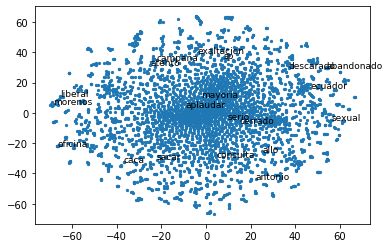

In [23]:
fig, ax = plt.subplots()

ax.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5)
for i in words_20:
    ax.annotate(
        model.wv.index_to_key[i], (tsne_results[i, 0], tsne_results[i, 1]), fontsize=9)


### **Clustering**

Se optó por realizar `Gaussian Mixture`, dado que toma en cuenta la varianza de los datos y los clusters en el modelo gaussiano no tienden a sobreponerse, por lo que no generan ambieguedades como empleando `K-means`.

In [24]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 100).fit(list(words_vectors.values()))


Ademas, el modelo ofrece la probabilidad de que cada elemento pertenezca a cada uno de los clusters, es decir, provee mayor información que una simple clasificación.

In [25]:
labels = gmm.predict(list(words_vectors.values()))
labels

array([28, 78, 51, ..., 29, 28, 21], dtype=int64)

Es posible observar la gráfica con los reusltados del TSNE.

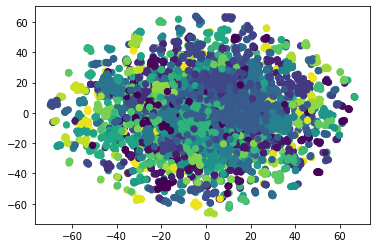

In [26]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=labels, s=40, cmap='viridis')


Más importante, es posible aplicar el método gausseano a los resultados del TSNE para obtener una agrupación con mayor sentido y que ofrece más información.

In [27]:
gmm_tsne = GaussianMixture(n_components=100).fit(tsne_results)

In [28]:
labels = gmm_tsne.predict(tsne_results)
labels


array([58, 82, 16, ..., 80, 22, 48], dtype=int64)

Se puede observar como resaltan los grupos de palabras al realizar una gráfica de los datos obtenidos.

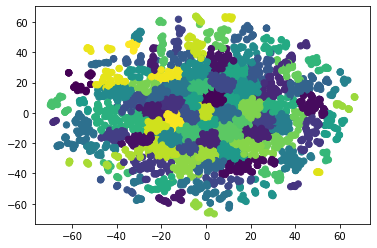

In [29]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=labels, s=40, cmap='viridis')


In [30]:
gmm_tsne.predict(tsne_results[model.wv.key_to_index["feliz"]].reshape(1, -1))


array([74], dtype=int64)

Finalmente, se define la función principal de la interfaz gráfica que limpia la palabra ingresada y encuentra sus tres sinonimos y tres antonimos. 

In [32]:
def funcion(Sinonimo_Antonimo, word):

    new_word = preprocessing_tweet(word)

    if Sinonimo_Antonimo == "sinonimo":
        simils = model.wv.most_similar(positive=[new_word])
        ans = simils[0][0] + '\n' + simils[1][0] + '\n' + simils[2][0]
    elif Sinonimo_Antonimo == "antonimo":
        simils = model.wv.most_similar(negative=[new_word])
        ans = simils[0][0] + '\n' + simils[1][0] + '\n' + simils[2][0]
        
    return ans 
        
    

### **Interfaz Gráfica**

Con el fin de generar una interacción amigable con el usuario, se realiza una interfaz gráfica empleando la libreria `gradio`.

In [44]:
import gradio as gr
iface = gr.Interface(fn = funcion, inputs = [gr.inputs.Dropdown(["sinonimo", "antonimo"]), "text"], outputs = "textbox")
iface.launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x2c188b7fee0>,
 'http://127.0.0.1:7860/',
 None)

Traceback (most recent call last):
  File "C:\Users\Isabella\AppData\Local\Programs\Python\Python39\lib\site-packages\gradio\routes.py", line 215, in predict
    prediction, durations = await run_in_threadpool(
  File "C:\Users\Isabella\AppData\Local\Programs\Python\Python39\lib\site-packages\starlette\concurrency.py", line 39, in run_in_threadpool
    return await anyio.to_thread.run_sync(func, *args)
  File "C:\Users\Isabella\AppData\Local\Programs\Python\Python39\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\Users\Isabella\AppData\Local\Programs\Python\Python39\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\Isabella\AppData\Local\Programs\Python\Python39\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run(func, *args)
  File "C:\Users\Isabella\App

# **Conclusiones**

1. El resultado final, y en general cualquier algoritmo de procesamiento de lenguaje natural solo puede ser tan bueno como la calidad de los datos ingresados. El hecho de tomar twitter como la fuente de información para el proyecto, le ocasiona conficto al modelo y contamina su proceso de aprendizaje, dado que las personas tienden a escribir descuidadamente y a cometer errores de redacción y ortografia. 

2. Inicialmente, la mayoria de los algoritmos están pensados para trabajar con datos en ingles, de forma que al tomar palabras en español la lematización tiende a confundirse y realizar procesos incorrectos, por ejemplo, tomar apellidos y corregirlos a palabras como sustantivos, adjetivos, etc. Además, tuvo una dificultad al identificar el alfabeto coreano como un caracter especial.

3. Es posible notar una propiedad de simetria en los sinonimos y antonimos, la cual se deriva del calculo de distancias entre palabras y su resultado en vectores. Además, durante la sección de factorización de matrices es posible encontrar topicos que tienen sentido con respecto a la situacion actual del pais y que guardan una relación en ellos.

<div style="text-align: right"><b> Ana Valentina López Chacón & Isabella Martínez Martínez & Sara Julieth Zuleta Quevedo. </b></div>